# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

Untar the data at `URLs.IMDB_SAMPLE` and save the path to `path`.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)

Open the csv file at `path/'texts.csv'` and show the first few rows.

In [4]:
df = pd.read_csv(path/'texts.csv')

NameError: name 'path' is not defined

Show the `text` field contents at index 1.

In [5]:
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [6]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Create a data bunch from the csv, ignoring the `is_valid` field for now.

In [3]:
data_lm = (TextList.from_df(df)
    .split_by_rand_pct()
    .label_for_lm()
    .databunch())

NameError: name 'df' is not defined

Save the databunch you just created.

In [18]:
data_lm.save()

Load the data from `path`.

In [9]:
data_lm = load_data(path)

### Tokenization

Create a `TextClasDataBunch` from the `texts.csv` file and save it to `data`. Show a batch.

In [9]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


What are the four main things we did *in addition to* just splitting the text into words?

- we split the `'s'` into a separate token
- we separated unknown tokens into their own thing
- we cleaned out any html
- contractions like `didn't` were split into their parts like `did` and `n't`

### Numericalization

Print out the first 10 vocab values.

In [11]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

Show the first example in the training dataset represented as text.

In [12]:
data.train_ds[0][0]

Text xxbos xxmaj apparently there 's a very good reason why i never heard about " xxmaj dr. xxmaj hackenstein " before me and a couple of mates accidentally stumbled upon it and stupidly decided to give it a chance . xxmaj that reason is : it sucks ! xxmaj it 's a very pointless , dull , xxunk and totally xxunk horror comedy / parody . xxmaj actually , to be honest , i 'm not even sure if this was meant as a comedy because sometimes the script takes itself quite seriously and tries really hard to be a really ambitious and original late 80 's horror effort . xxmaj in the year xxunk , at the dawn of a new era in medical science according to the opening sequences , xxmaj dr. xxmaj elliot xxmaj hackenstein needs exactly three women  no more , no less  to xxunk his beloved wife whom he accidentally killed . xxmaj she 's only just a living head left now , but the stupid body xxunk only provide male cadavers . xxmaj so when xxmaj dr. xxmaj hackenstein yells out " i need three female bodies 

Show the first example in the training dataset represented as numbers (i.e. in numericalized form).

In [13]:
data.train_ds[0][0].data[:10]

array([  2,   5, 649,  55,  23,  13,  70,  68, 343, 163])

### With the data block API

Use the datablock API to create a databunch. Hints:
- You'll want to start with a `TextList`
- You'll want to split the data based on the `is_valid` column
- You'll want to label the df using the label

In [14]:
data = (TextList.from_csv(path, 'texts.csv')
        .split_from_df('is_valid')
        .label_from_df('label')
        .databunch()) 

## Language model

Batch size should be 48; assign it to `bs`.

In [5]:
bs = 48

Untar the full dataset at `URLs.IMDB` and save the path to `path`. Show the contents of `path`.

In [7]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/paperspace/.fastai/data/imdb/data_clas.pkl'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_save.pkl'),
 PosixPath('/home/paperspace/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/paperspace/.fastai/data/imdb/test'),
 PosixPath('/home/paperspace/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/paperspace/.fastai/data/imdb/README'),
 PosixPath('/home/paperspace/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/paperspace/.fastai/data/imdb/unsup'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_clas'),
 PosixPath('/home/paperspace/.fastai/data/imdb/models'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_lm'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train')]

Show the contents of `path/'train'`.

In [8]:
(path/'train').ls()

[PosixPath('/home/paperspace/.fastai/data/imdb/train/neg'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train/pos')]

Create a language model from the data at `path`. Include the `unsup` folder this time. We're going to create a language model, which predicts the next word in a sequence. This will be a useful starting point for our sentiment analysis model.

In [9]:
data_full = (TextList.from_folder(path)
             .filter_by_folder(['train', 'valid', 'unsup'])
             .split_by_rand_pct()
             .label_for_lm()
             .databunch(bs=bs))

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes). Save the data to `data_lm.pkl`.

In [60]:
data_full.save('data_lm')

Load the data from `data_lm.pkl` to `data_lm`.

In [10]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

Show a batch.

In [11]:
data_lm.show_batch()

idx,text
0,"are xxmaj ringing "" , both of which opened with very similar views ( and both of which had lyrics by xxmaj adolph xxmaj green , who appears in the film as xxmaj leo ) . xxmaj there are many parallels to classic comedy in a broader sense as well , like the relationship between has - been swashbuckling icon xxmaj alan xxmaj swann ( xxmaj peter o'toole ) and"
1,"found myself hooked watching this film after about 20 minutes . a multi - layered , memorable performance from the xxmaj queen of the xxmaj hangers . xxbos xxmaj policewoman xxmaj carole xxmaj mathews goes "" undercover "" to join xxmaj marie xxmaj windsor , xxmaj beverly xxmaj garland , and xxmaj jil xxmaj xxunk in prison . xxmaj the "" xxmaj gang of xxmaj four "" escape , and"
2,"xxmaj flynn . xxmaj when i think of xxmaj western heroes , i generally xxup don't think about them starring someone from "" xxmaj down xxmaj under "" , but this really was n't a problem . xxmaj flynn was just fine . \n \n xxmaj for me , part of the reason the film worked was its marvelous supporting cast . xxmaj my favorite of xxmaj flynn 's"
3,"you are familiar with xxmaj john xxmaj lennon 's early life , including the development of his various bands , and the evolution of the xxmaj beatles through xxmaj germany and the xxmaj liverpool scene , then this movie does n't offer much in the way of history . xxmaj the history is accurate by most accounts . xxmaj the actors portraying the xxmaj beatles a relatively similar in looks"
4,"after watching "" xxup hot xxup fuzz "" ( which is amazing by the way ) but it did n't make me laugh . xxmaj for the first time ever i have tried to get my money back from the cinema and believe me i have seen some bad films but this took the biscuit . xxmaj please do n't waste your money on this film and encourage more ."


Create a `language_model_learner` with architecture `AWD_LSTM` and `drop_mult` of 0.3.

In [21]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Run the learning rate finder and pick an LR (you should land somewhere around 1e-2).

In [65]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


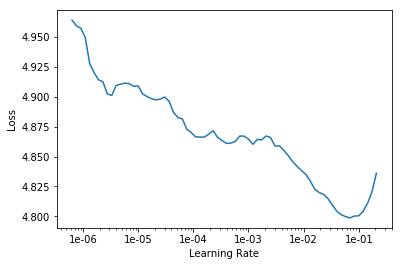

In [71]:
learn.recorder.plot(skip_end=20)

Fit the model, using the lr computed above, with `moms=(0.8,0.7)`.

In [72]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.178954,4.053694,0.293334,57:27


Save the model to `fit_head`.

In [75]:
learn.save('fit_head')

Load the model from `fit_head`.

In [22]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (60000 items)
x: LMTextList
xxbos " xxmaj my xxmaj favorite xxmaj year " is a very funny and charming piece of nostalgia that wears just a little bit too much of its sincerity on its sleeve . xxmaj the opening shots of the classic xxmaj new xxmaj york skyline bring back fond memories of films set in xxmaj new xxmaj york like " xxmaj on the xxmaj town " and " xxmaj bells xxmaj are xxmaj ringing " , both of which opened with very similar views ( and both of which had lyrics by xxmaj adolph xxmaj green , who appears in the film as xxmaj leo ) . xxmaj there are many parallels to classic comedy in a broader sense as well , like the relationship between has - been swashbuckling icon xxmaj alan xxmaj swann ( xxmaj peter o'toole ) and his chauffeur / manservant which mirrors the classic xxmaj jeeves and xxmaj wooster dichotomy loosely . 
 
  xxmaj the story is very straightforward  xxmaj swann must make an appearance on a xxup tv variety

Unfreeze the model and run for 10 epochs with a lr that is 10% of the one you used last (same `moms`).

In [23]:
# %%capture output
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.117712,4.029732,0.295634,57:08


Save this model to `fine_tuned`.

In [24]:
learn.save('fine_tuned')

Load the model from `fine_tuned`.

In [25]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (60000 items)
x: LMTextList
xxbos " xxmaj my xxmaj favorite xxmaj year " is a very funny and charming piece of nostalgia that wears just a little bit too much of its sincerity on its sleeve . xxmaj the opening shots of the classic xxmaj new xxmaj york skyline bring back fond memories of films set in xxmaj new xxmaj york like " xxmaj on the xxmaj town " and " xxmaj bells xxmaj are xxmaj ringing " , both of which opened with very similar views ( and both of which had lyrics by xxmaj adolph xxmaj green , who appears in the film as xxmaj leo ) . xxmaj there are many parallels to classic comedy in a broader sense as well , like the relationship between has - been swashbuckling icon xxmaj alan xxmaj swann ( xxmaj peter o'toole ) and his chauffeur / manservant which mirrors the classic xxmaj jeeves and xxmaj wooster dichotomy loosely . 
 
  xxmaj the story is very straightforward  xxmaj swann must make an appearance on a xxup tv variety

In [26]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [40]:
def speak(words):
    if len(words.split()) == N_WORDS:
        return words 
    return speak(learn.predict(words, temperature=0.75))

speak(TEXT)

'I liked this movie because i was a huge fan of "                                                 the  old " .     i also liked the series the first time i have seen "                                                                                a            " mad scientist .      i was looking forward to his performance'

    Using the variables above, create a stream of text using `learn.predict` with a temperature of 0.75. 

Save the encoder (the part the updates the hidden state) to `fine_tuned_enc`.

In [41]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Once again untar the data from `URLs.IMDB` and save the path to `path`.

In [12]:
cls_path = untar_data(URLs.IMDB)

Create a data bunch with the following characteristics:
- Should start as a `TextList` from the folder at `path` above, with vocab specified to be `data_lm.vocab`
- Should split data by folder, where the test data comes from the `test` directory
- Label by folder (`pos` or `neg`)
- Batch size should be `bs`, which was created earlier

This should be assigned to the variable `data_clas`, and then saved to `data_clas.pkl`.

In [15]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/imdb/data_clas.pkl'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_save.pkl'),
 PosixPath('/home/paperspace/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/paperspace/.fastai/data/imdb/test'),
 PosixPath('/home/paperspace/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/paperspace/.fastai/data/imdb/README'),
 PosixPath('/home/paperspace/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/paperspace/.fastai/data/imdb/unsup'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_clas'),
 PosixPath('/home/paperspace/.fastai/data/imdb/models'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/paperspace/.fastai/data/imdb/data_lm'),
 PosixPath('/home/paperspace/.fastai/data/imdb/train')]

In [20]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             .split_by_folder(valid='test')
             .label_from_folder()
             .databunch(bs=bs//2))

In [58]:
data_clas.save('data_clas')

Load the data from `data_clas.pkl` with batch size `bs`.

In [16]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

Show a batch. 

In [17]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos * * * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . * * * \n \n xxmaj before i begin , i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that",neg
"xxbos xxmaj jim xxmaj carrey is back to much the same role that he played in xxmaj the xxmaj mask , a timid guy who is trying to get ahead in the world but who seems to be plagued with bad luck . xxmaj even when he tries to help a homeless guy from being harassed by a bunch of hoodlums ( and of course they have to be xxmaj",pos
"xxbos xxmaj this film reminds me of 42nd xxmaj street starring xxmaj bebe xxmaj daniels and xxmaj ruby xxmaj keeler . xxmaj when i watch this film a lot of it reminded me of 42nd xxmaj street , especially the character xxmaj eloise who 's a temperamental star and she ends up falling and breaks her ankle , like xxmaj bebe xxmaj daniels did in 42nd xxmaj street and another",pos
"xxbos xxmaj despite loving xxmaj rita xxmaj hayworth , finding the final few sequences of the film intriguing and being able to appreciate some of the subtler "" symbolic "" aspects of the cinematography , xxmaj the xxmaj lady from xxmaj shanghai did n't quite work for me . i had a problem with most of the performances , the script and the overall structure . xxmaj and in a",pos


Create a `text_classifier_learner` assigned to variable `learn` using `data_clas`, with arch `AWD_LSTM` and `drop_mult` of 0.5. Load the encoder that was fine-tuned earlier (from `fine_tuned_enc`).

In [21]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [22]:
learn.load_encoder('fine_tuned_enc')

Find the LR. Should land somewhere around 2e-2. You should land at an accuracy around 0.92696 and a loss of 0.1972.

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


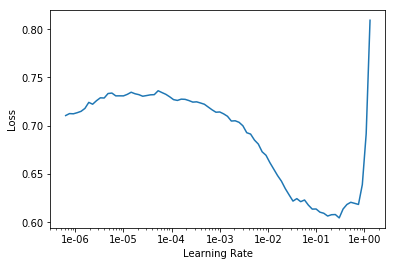

In [67]:
learn.recorder.plot()

Fit one cycle, again with `moms=(0.8,0.7)`.

In [69]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.432185,0.342155,0.856800,09:01


Save the model to `first`.

In [70]:
learn.save('first')

Load the model from `first`.

In [71]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

Freeze the model up to layer -2, and fit another cycle, this time with lrs `slice(1e-2/(2.6**4),1e-2)`. You should land at an accuracy around 0.9378 and a loss of 0.1692.

In [72]:
learn.freeze_to(-2)

In [73]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.360961,0.259589,0.893920,11:43


Save the model to `second`.

In [74]:
learn.save('second')

Load the model from `second`.

In [17]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

Freeze the model to layer -3. Fit another cycle with lrs `slice(5e-3/(2.6**4),5e-3)`. You should land at an accuracy around 0.9396 and a loss of 0.1657.

In [23]:
learn.freeze_to(-3)

In [24]:
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.305979,0.218381,0.913920,17:41


Save the model to `third`.

In [25]:
learn.save('third')

Load the model from `third`.

In [26]:
learn.load('third')

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/basic_train.py:327: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj basically , xxmaj cruel xxmaj intentions 2 is xxmaj cruel xxmaj intentions 1 , again , only poorly done . xxmaj the story is exactly the same as the first one ( even some of the lines ) , with only a few exceptions . xxmaj the cast is more unknown , and definitely less talented . xxmaj instead of being seductive and drawing me into watching it , i ended up feeling dirty because it compares to watching a soft - core porn . i 'm not sure whether to blame some of the idiotic lines on the actors or the writers ... and i always feel bad saying that , because i know how hard it is to do both ... but it was basically a two - hour waste of my life . xxmaj it literally amazes me that some movies get made , and this is no exception ... i ca n't believe they 'd make a third one .,xxbos i had been subjected to this movie for a relationship class in my school . xxmaj as figured it was nothing captivating and 

Unfreeze the model, and fit 2 cycles with lr `slice(1e-3/(2.6**4),1e-3)`. You should land at an accuracy around 0.9439 and a loss around 0.1534.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.288769,0.201997,0.920880,21:24


Make a prediction on the string "I really loved that movie, it was awesome!".

In [28]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([0.0054, 0.9946]))

In [29]:
learn.predict("That movie sucked")

(Category neg, tensor(0), tensor([0.7802, 0.2198]))